In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from matplotlib import cm
from sklearn import metrics
from sklearn.metrics import silhouette_samples, completeness_score, homogeneity_score
from sklearn.cluster import KMeans 
from sklearn.datasets import fetch_california_housing, load_iris

In [2]:
np.set_printoptions(suppress = True, precision = 2, linewidth = 120) # Set global print options
pd.options.display.float_format = '{:,.2f}'.format # Set the global display option

Clustering with California Housing Data

In [3]:
# Fetch the dataset
housing = fetch_california_housing()
print(housing.data[:5])

[[   8.33   41.      6.98    1.02  322.      2.56   37.88 -122.23]
 [   8.3    21.      6.24    0.97 2401.      2.11   37.86 -122.22]
 [   7.26   52.      8.29    1.07  496.      2.8    37.85 -122.24]
 [   5.64   52.      5.82    1.07  558.      2.55   37.85 -122.25]
 [   3.85   52.      6.28    1.08  565.      2.18   37.85 -122.25]]


In [4]:
print(housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
# Create a Pandas DataFrame
data = pd.DataFrame(housing.data, columns = housing.feature_names)
data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23
1,8.30,21.00,6.24,0.97,"2,401.00",2.11,37.86,-122.22
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25


In [6]:
kmeans = KMeans(n_clusters = 5, max_iter = 500, verbose = 0) # Initialize the K-Means clustering
kmeans.fit(data) # Fit the model
clusters = kmeans.predict(data) # Predict the clusters

c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [7]:
dfCluster = pd.DataFrame(clusters, columns = ["Cluster"])
dfCluster.value_counts() # Count the number of occurrences of each cluster label

Cluster
1          10804
2           7343
0           2086
4            384
3             23
Name: count, dtype: int64

In [8]:
# Create centroids from the K-Means
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = housing.feature_names)
centroids

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,3.85,21.07,5.13,1.07,"3,074.06",3.52,35.20,-119.18
1,3.92,31.68,5.65,1.13,767.75,2.79,35.87,-119.76
2,3.79,27.10,5.19,1.06,"1,640.97",3.06,35.44,-119.44
3,4.75,9.09,6.16,1.06,"14,014.61",3.60,35.14,-119.08
4,4.10,14.69,5.42,1.07,"6,100.53",8.67,35.14,-119.02


In [9]:
def cluster_sizes(clusters):
    
    # Initialize an empty dictionary to store the size of each cluster
    size = {}

    # Get the unique cluster labels
    cluster_labels = np.unique(clusters)

    # Determine the number of unique clusters
    n_clusters = cluster_labels.shape[0]

    # Count how many data points belong to each cluster and store this count in the dictionary
    for c in cluster_labels:
        size[c] = len(data[clusters == c])
        
    return size

In [10]:
# Call the function
size = cluster_sizes(clusters)

for c in size.keys():
    print("Size of Cluster", c, "=", size[c])

Size of Cluster 0 = 2086
Size of Cluster 1 = 10804
Size of Cluster 2 = 7343
Size of Cluster 3 = 23
Size of Cluster 4 = 384


In [11]:
# Calculate the silhouette scores
silhouettes = metrics.silhouette_samples(data, clusters)
print(silhouettes.mean())

0.556361516841067


In [12]:
def plot_silhouettes(data, clusters):
    
    # Get the unique cluster labels and the number of clusters
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]

    # Calculate the silhouette values
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric = 'euclidean')
    
    # Initialize variables to track the lower and upper bounds
    c_ax_lower, c_ax_upper = 0, 0

    # List to store the tick positions for cluster labels
    cticks = []

    for i, k in enumerate(cluster_labels):

        # Get the silhouette values for the current cluster 'k'
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()

        # Calculate the upper bound
        c_ax_upper += len(c_silhouette_vals)

        # Plot the horizontal bars for the current cluster's silhouette values
        color = cm.jet(float(i) / n_clusters)
        pl.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height = 1.0, edgecolor = 'none', color = color)

        # Append the center position for the current cluster
        cticks.append((c_ax_lower + c_ax_upper) / 2)

        # Update the lower bound
        c_ax_lower += len(c_silhouette_vals)
    
    # Calculate the average silhouette score
    silhouette_avg = np.mean(silhouette_vals)

    # Plot a vertical line at the average silhouette score
    pl.axvline(silhouette_avg, color = "red", linestyle = "--") 
    pl.yticks(cticks, cluster_labels)
    pl.ylabel('Cluster')
    pl.xlabel('Silhouette Coefficient')
    pl.tight_layout()
    pl.show()
    
    return

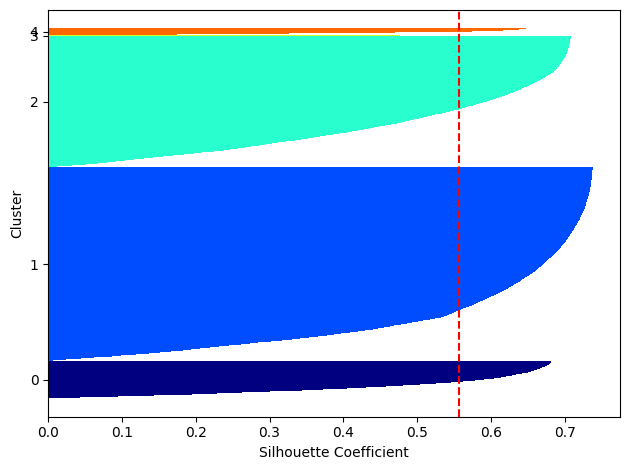

In [13]:
# Call the function
plot_silhouettes(data, clusters)

Clustering with Iris Plant Data

In [14]:
# Load the dataset
iris = load_iris()

In [15]:
data = iris.data # Extract the feature data
target = iris.target # Extract the target labels

In [16]:
irisDF = pd.DataFrame(data, columns = iris.feature_names)
irisDF.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20


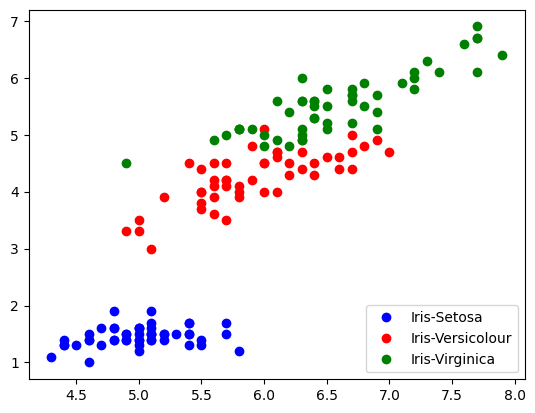

In [17]:
# Plot the data points for each species of iris flower
pl.plot(data[target == 0, 0], data[target == 0, 2], 'bo')
pl.plot(data[target == 1, 0], data[target == 1, 2], 'ro')
pl.plot(data[target == 2, 0], data[target == 2, 2], 'go')
pl.legend(('Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica'), loc = 4)
pl.show()

In [18]:
iris_kmeans = KMeans(n_clusters = 3, max_iter = 500, verbose = 0, n_init = 5) # Initialize the K-Means clustering
iris_kmeans.fit(irisDF) # Fit the model
clusters = iris_kmeans.predict(data) # Predict the clusters

c:\Users\wodnj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [19]:
# Call the function
size = cluster_sizes(clusters)

for c in size.keys():
    print("Size of Cluster", c, "=", size[c])

Size of Cluster 0 = 50
Size of Cluster 1 = 61
Size of Cluster 2 = 39


In [20]:
# Create centroids from the K-Means
iris_centroids = pd.DataFrame(iris_kmeans.cluster_centers_, columns = iris.feature_names)
iris_centroids

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.01,3.43,1.46,0.25
1,5.88,2.74,4.39,1.43
2,6.85,3.08,5.72,2.05


In [21]:
# Calculate the completeness score
print(completeness_score(target, clusters))

0.7474865805095324


In [22]:
# Calculate the homogeneity score
print(homogeneity_score(target, clusters))

0.7364192881252849


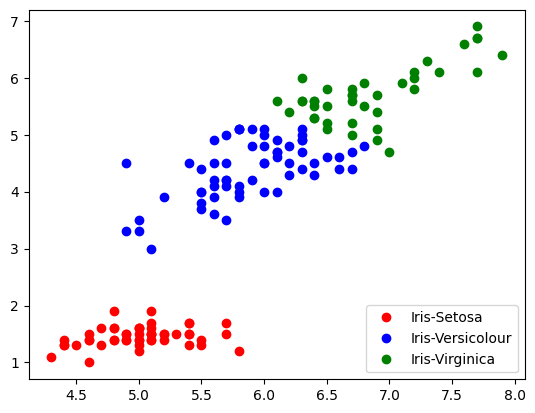

In [23]:
# Plot the clustered data points based on the clustering results
pl.plot(data[clusters == 0, 0], data[clusters == 0, 2], 'ro')
pl.plot(data[clusters == 1, 0], data[clusters == 1, 2], 'bo')
pl.plot(data[clusters == 2, 0], data[clusters == 2, 2], 'go')
pl.legend(('Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica'), loc = 4)
pl.show()

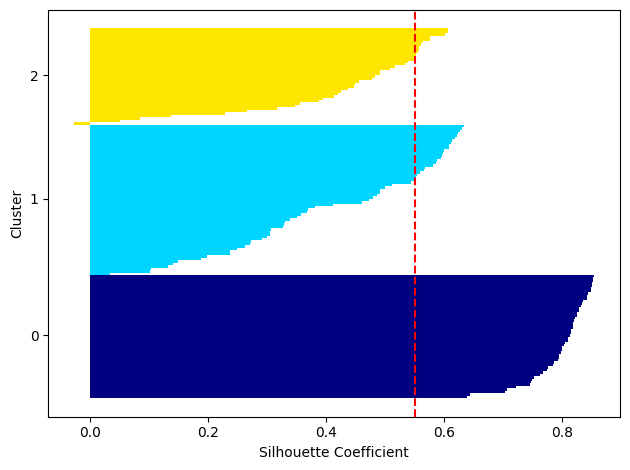

In [24]:
# Call the function
plot_silhouettes(data, clusters)